In [158]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import time
import pandas as pd
from subprocess import Popen,PIPE
import sys
from scipy.signal import savgol_filter
from multiprocessing import Process

'''
1. make like the energyTemp stuff
2. run program from python
3. run more than just one instance in parrall to save time i guess
4. 2 or 4 processes need to give the machine more resouces
'''
#Data location
basicDataLocation = '/home/cm/CLionProjects/MoleDymCode/AData/Clusters'

#Natur Konstants
boltzmannConstant = 1.380649e-23 
electronVolt = 1.602176634e-19
boltzmannElectronVolt  = boltzmannConstant/electronVolt


#most basic file to list function
def readDataFromFile(fileLocation):
    #open file
    file = open(fileLocation,'r')
    #read from the file
    text = file.readlines()
    returnValue = []
    for line in text:
        returnValue.append(float(line[:-1]))
    
    file.close()
    return returnValue

#those functions just save the data and then look at it
def dataPlotterEnergyTemperatur(layerID):
    #file Locations
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturEnergyCurve" + str(layerID) + ".png"
    
    #get Energy
    energy = readDataFromFile(energyFileLocation)

    #get Temperatur
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #plot
    fig, ax = plt.subplots()
    ax.plot(temperatur,energy)
    ax.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
    ax.grid(which = 'minor', color = '#EEEEEE', linewidth = 0.5)
    ax.minorticks_on()
    plt.xlabel("Temperatur in K")
    plt.ylabel("Energy in eV")
    plt.savefig(imageSafeLocation)
    plt.show()
    return imageSafeLocation
    
def dataPlotterKineticEnergy(layerID):
    #File locations
    fileLocation = basicDataLocation + "/kineticEnergy" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/kineticEnergyCurve" + str(layerID) + ".png"
    
    #get the kinetic Energy
    kineticEnergy = readDataFromFile(fileLocation)
    
    #create time array
    timestep = 1
    lenght = len(kineticEnergy)
    time = np.arange(start = 0, stop = timestep*lenght, step = timestep)
    
    #filter data couse this looks way to messy
    df = pd.DataFrame(dict(x=kineticEnergy))
    kineticEnergyFiltered = df[["x"]].apply(savgol_filter, window_length=1001, polyorder=2)

    #plot
    fig, ax = plt.subplots()
    ax.plot(time,kineticEnergy)
    ax.plot(kineticEnergyFiltered,'r')
    ax.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
    ax.grid(which = 'minor', color = '#EEEEEE', linewidth = 0.5)
    ax.minorticks_on()
    plt.xlabel("Time in fs")
    plt.ylabel("Energy in eV")
    plt.savefig(imageSafeLocation)
    plt.show()
    return imageSafeLocation
    

def functionCall(layerID):
    #file locations
    programbasePath = "/home/cm/CLionProjects/MoleDymCode/cmake-build-release/"
    programName = "myproject"
    programCall = programbasePath + programName

    #call the c++ program 
    process = Popen([programCall,str(layerID)],stdout = PIPE, stderr= PIPE)
    Popen.wait(process)
    stdout, stderr = process.communicate()
    print(stdout)
    print(stderr)

def combinedFunction(layerID):
    print("Working on Cluster " + str(layerID) + "\n")
    functionCall(layerID)
    #dataPlotterKineticEnergy(layerID)
    #dataPlotterEnergyTemperatur(layerID)

def plotter():
    for layerID in range(14-3+1):
        dataPlotterKineticEnergy(layerID+3)
        #dataPlotterEnergyTemperatur(layerID+3)
        dataPlotterPotentialEnergyTemperatur(layerID+3)
        dataPlotterDiffEnergyTemperatur(layerID+3)
    
def callInParralel(valueArray):
    for v in valueArray:
        combinedFunction(v)
        #print("Working on Cluster " + str(v)+"\n")

def dataMaker():
    start = time.time()        
    #create Patterns
    '''
    #standard
    callPattern1 = np.array([3,4,12])
    callPattern2 = np.array([5,6,11])
    callPattern3 = np.array([8,9])
    callPattern4 = np.array([7,10])
    callPattern5 = np.array([13])
    callPattern6 = np.array([14])
    '''
    #finer for some
    callPattern1 = np.array([5])
    callPattern2 = np.array([6])
    callPattern3 = np.array([8])
    callPattern4 = np.array([7])
    callPattern5 = np.array([3])
    callPattern6 = np.array([4])
    #create Processes
    process1 = Process(target = callInParralel, args =(callPattern1,))
    process2 = Process(target = callInParralel, args =(callPattern2,))
    process3 = Process(target = callInParralel, args =(callPattern3,))
    process4 = Process(target = callInParralel, args =(callPattern4,))
    process5 = Process(target = callInParralel, args =(callPattern5,))
    process6 = Process(target = callInParralel, args =(callPattern6,))

    #start processes
    process1.start()
    process2.start()
    process3.start()
    process4.start()
    process5.start()
    process6.start()

    #wait till end
    process1.join()
    process2.join()
    process3.join()
    process4.join()
    process5.join()
    process6.join()
    
    #
    end = time.time()
    print("Done in")
    print(end - start)

def readClusterSizes(layerID):
    #reads the first line form the clusters which contains the number of Atoms
    clusterFile = basicDataLocation + "/cluster" + str(layerID) + ".xyz"
    with open(clusterFile) as f:
        number = f.readlines()[0].rstrip()
        
    return number
     
def calculateKineticEnergyBack(layerID):
    #data location
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    
    #read from file
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #calculation    
    nbAtoms = float(readClusterSizes(layerID))
    kineticEnergy = 1.5 * boltzmannElectronVolt * np.array(temperatur) * nbAtoms
    
    return kineticEnergy

def dataPlotterPotentialEnergyTemperatur(layerID):
    #TLDR i can not read
    
    #data location
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturPotentialEnergyCurve" + str(layerID) + ".png"
    
    #read from file
    energy = readDataFromFile(energyFileLocation)
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #potential Energy
    potentialEnergy = np.array(energy) - calculateKineticEnergyBack(layerID)
    
    #plot
    fig, ax = plt.subplots()
    ax.plot(temperatur,potentialEnergy)
    ax.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
    ax.grid(which = 'minor', color = '#EEEEEE', linewidth = 0.5)
    ax.minorticks_on()
    plt.xlabel("Temperatur in K")
    plt.ylabel("Energy in eV")
    plt.savefig(imageSafeLocation)
    plt.show()
    return imageSafeLocation

#gradient stuff
def dataPlotterDiffEnergyTemperatur(layerID):
    #file locations
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturEnergyCurveGradients" + str(layerID) + ".png"
    
    #get Energy
    energy = readDataFromFile(energyFileLocation)
    potentialEnergy = np.array(energy) - calculateKineticEnergyBack(layerID)
    
    #get Temperatur
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #####
    grad = np.gradient(potentialEnergy)/np.gradient(temperatur)
    #print(grad) 
    #print((np.where(grad == np.amax(grad)))[0])
    #plot
    fig, ax = plt.subplots()
    ax.plot(grad)
    ax.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
    ax.grid(which = 'minor', color = '#EEEEEE', linewidth = 0.5)
    ax.minorticks_on()
    plt.savefig(imageSafeLocation)
    plt.show() 
    return imageSafeLocation

def plotMeltingToSize():
    print("HI")
    

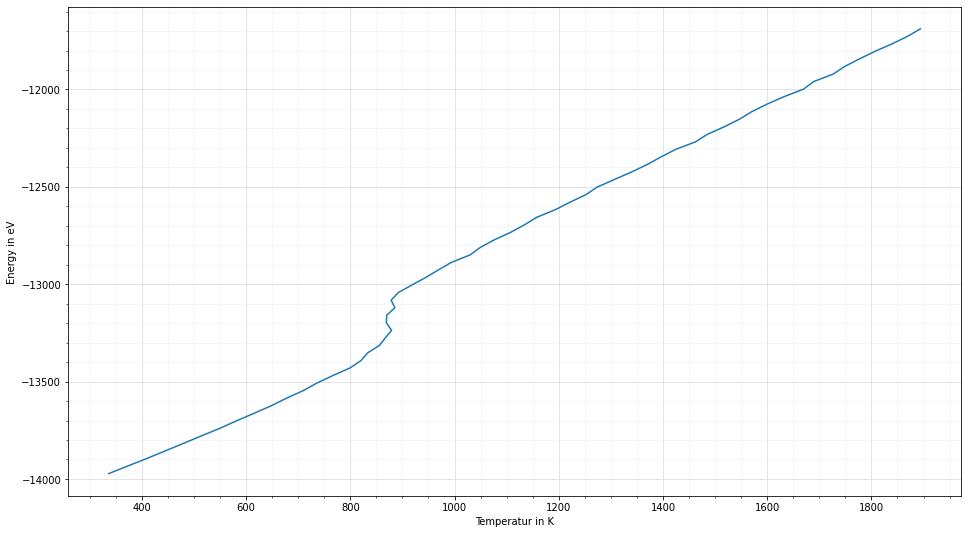

'/home/cm/CLionProjects/MoleDymCode/AData/Clusters/temperaturEnergyCurve10.png'

In [143]:
dataPlotterEnergyTemperatur(10)

Working on Cluster 5

Working on Cluster 6
Working on Cluster 8

Working on Cluster 7


Working on Cluster 3

Working on Cluster 4

b'Molecular Dynamics Project\nLayerID3\nStarting Simulation\n'
b''
b'Molecular Dynamics Project\nLayerID4\nStarting Simulation\n'
b''
b'Molecular Dynamics Project\nLayerID5\nStarting Simulation\n'
b''
b'Molecular Dynamics Project\nLayerID6\nStarting Simulation\n'
b''
b'Molecular Dynamics Project\nLayerID7\nStarting Simulation\n'
b''
b'Molecular Dynamics Project\nLayerID8\nStarting Simulation\n'
b''
Done in
16544.902993440628


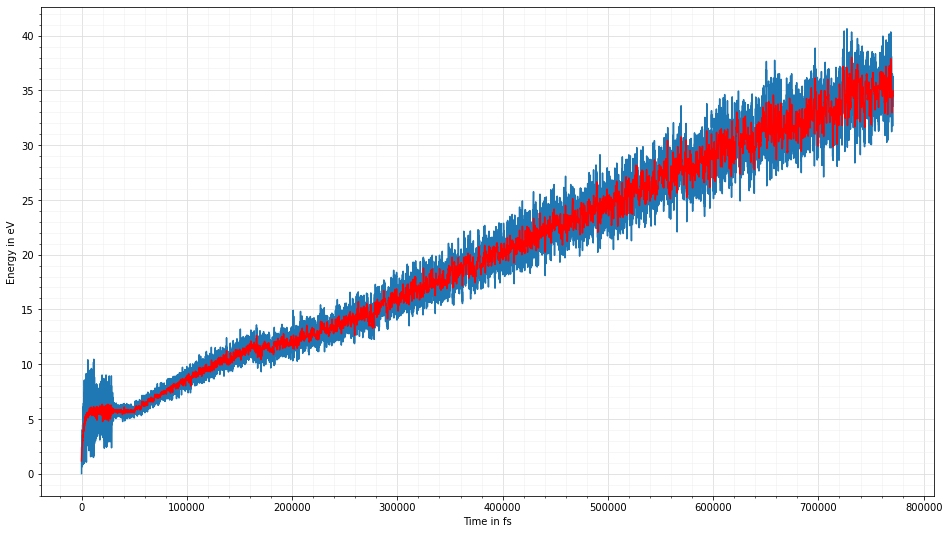

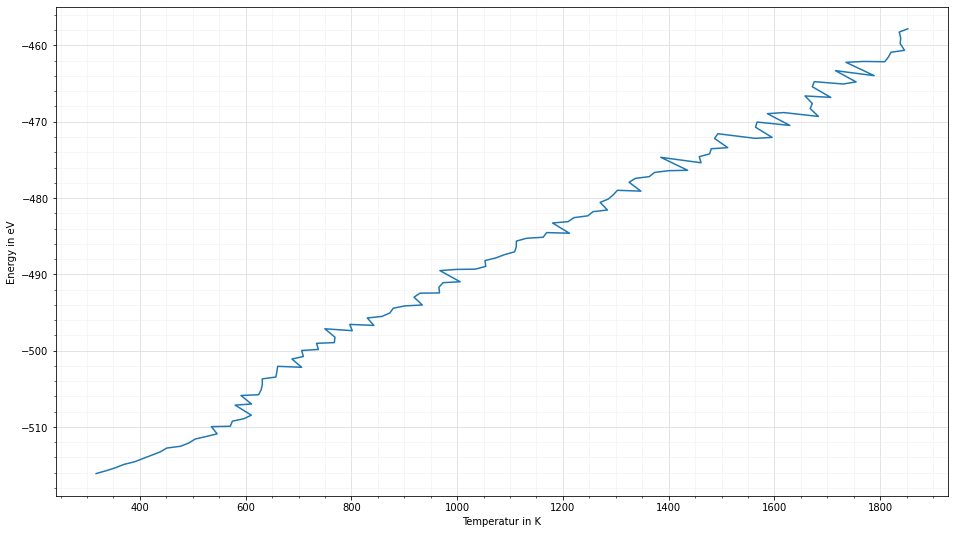

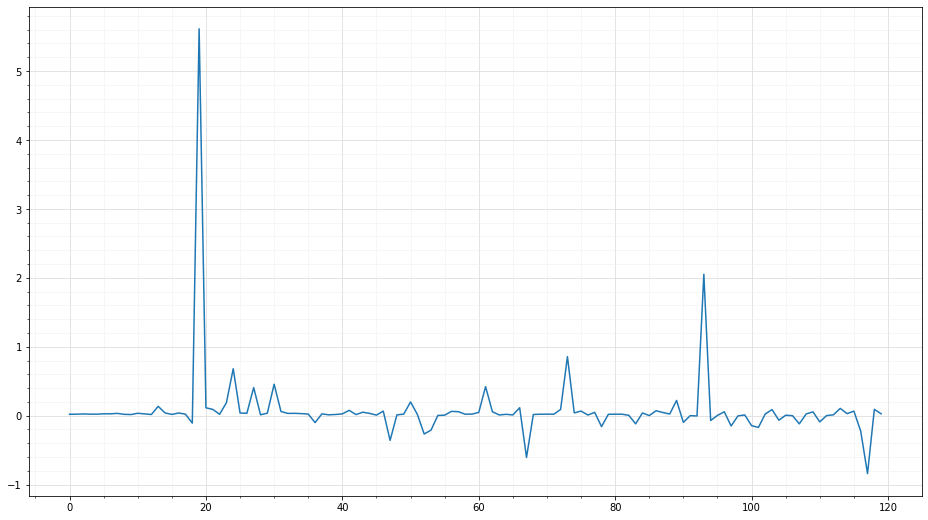

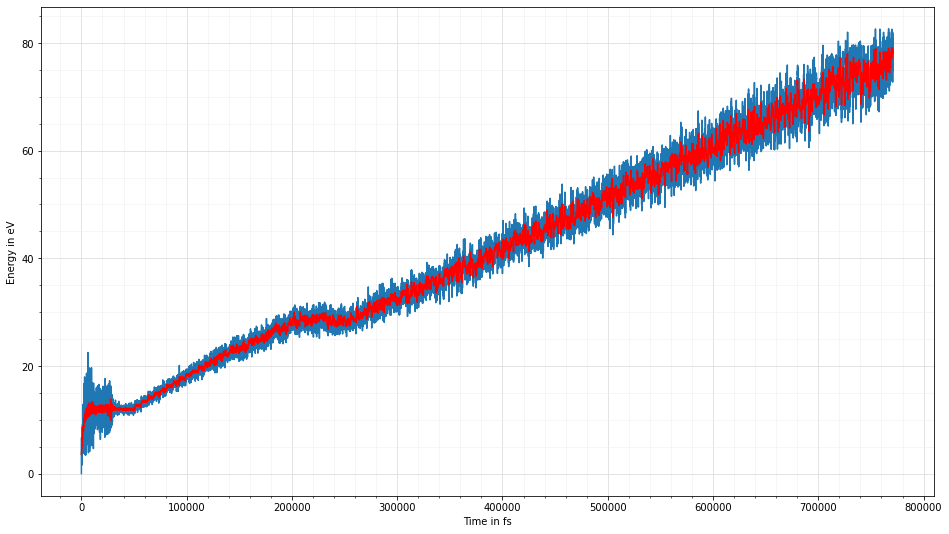

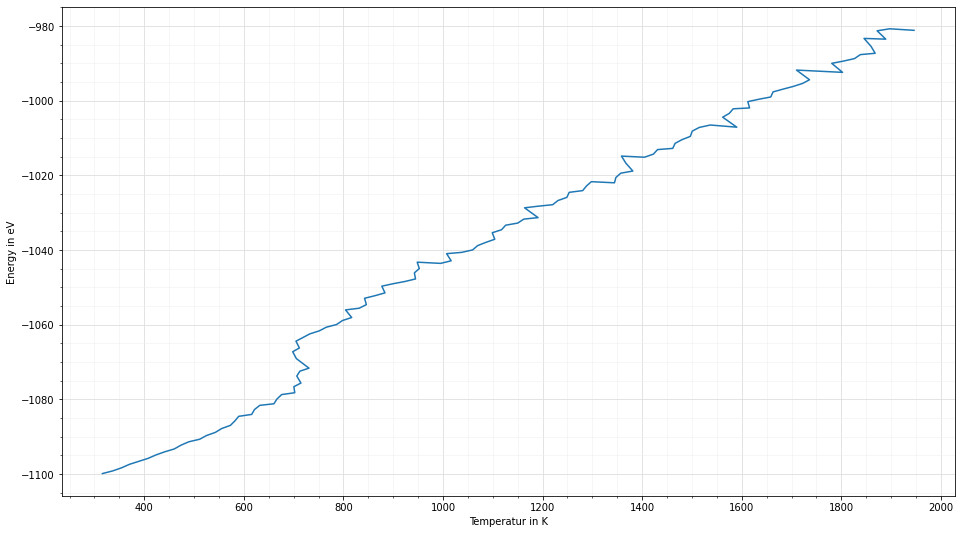

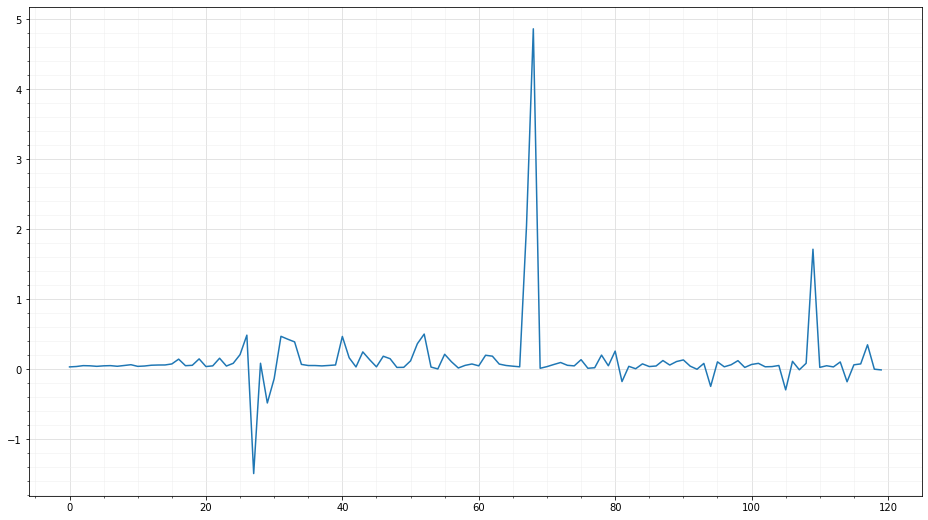

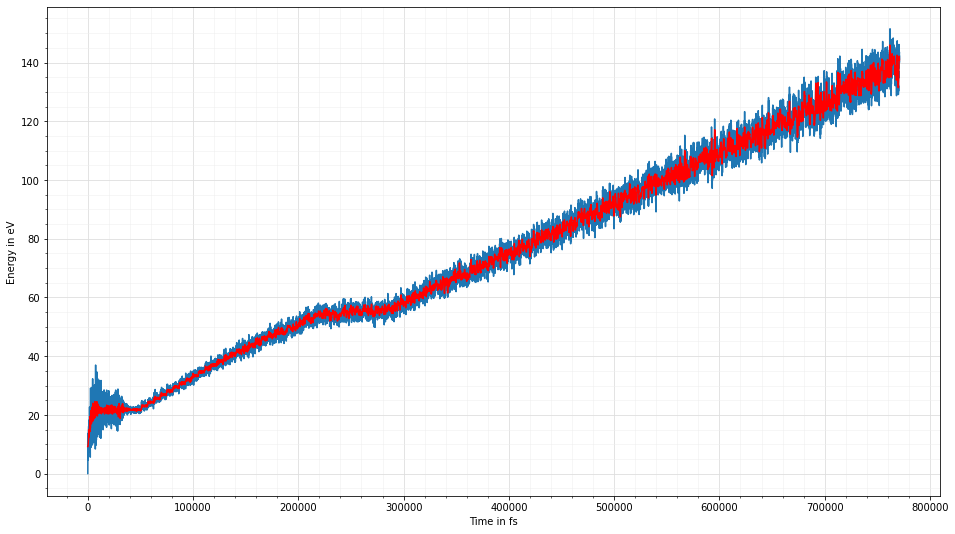

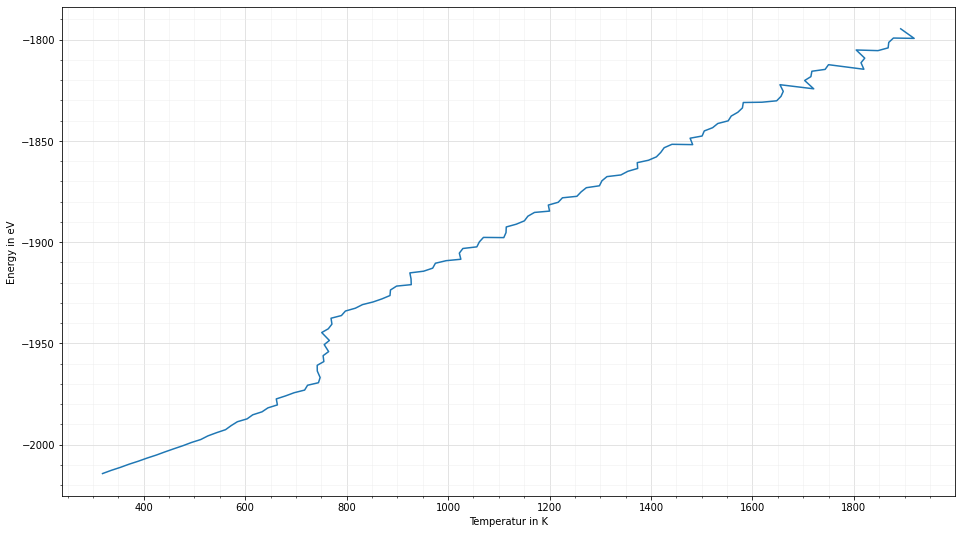

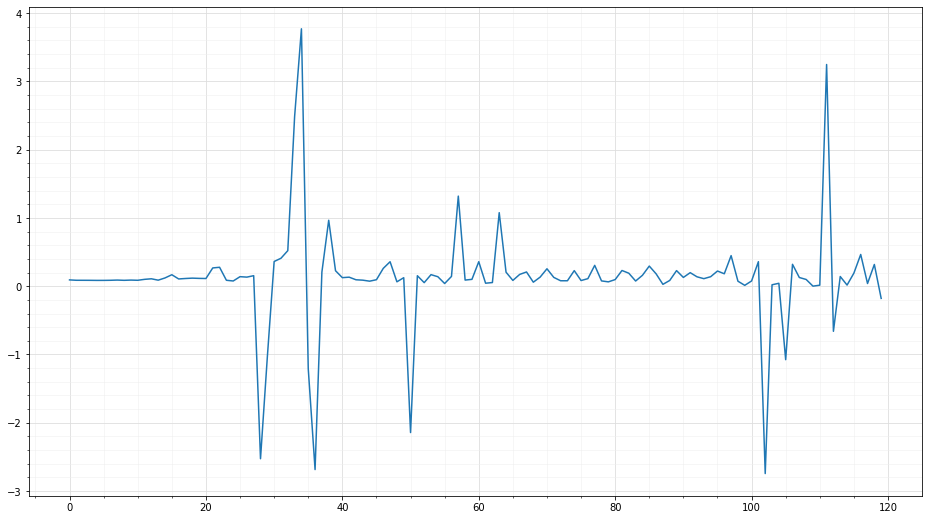

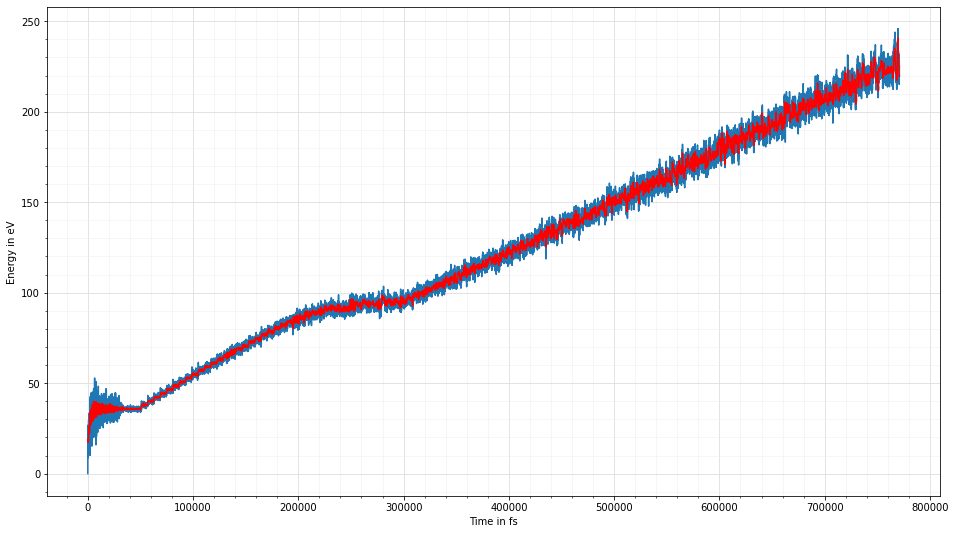

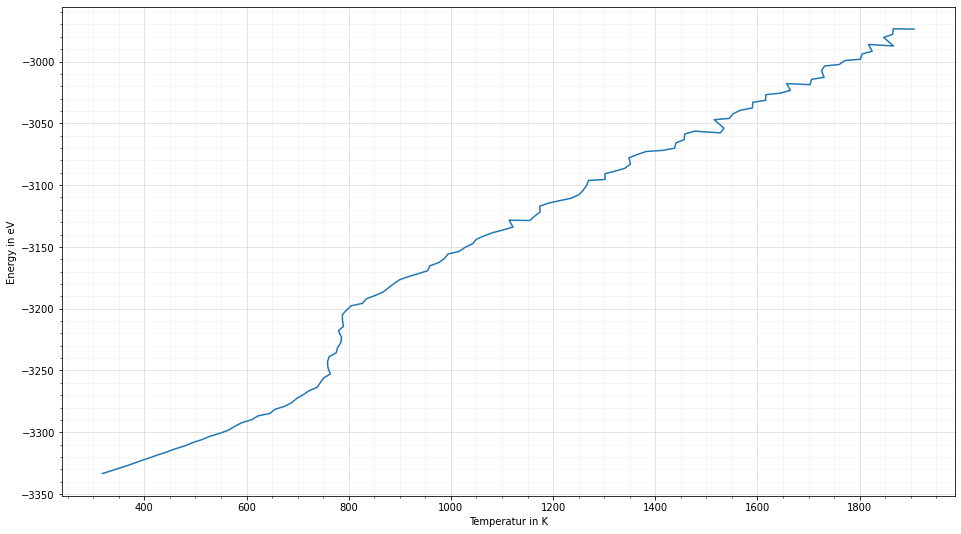

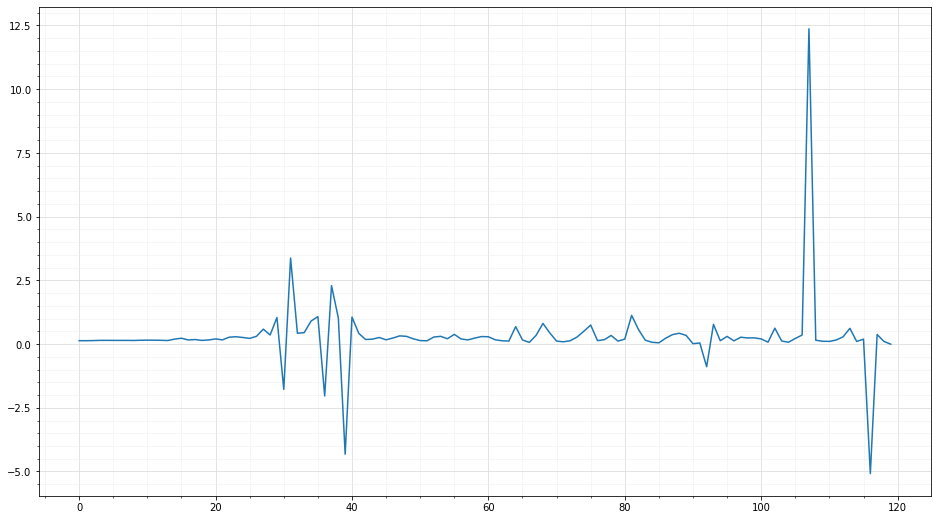

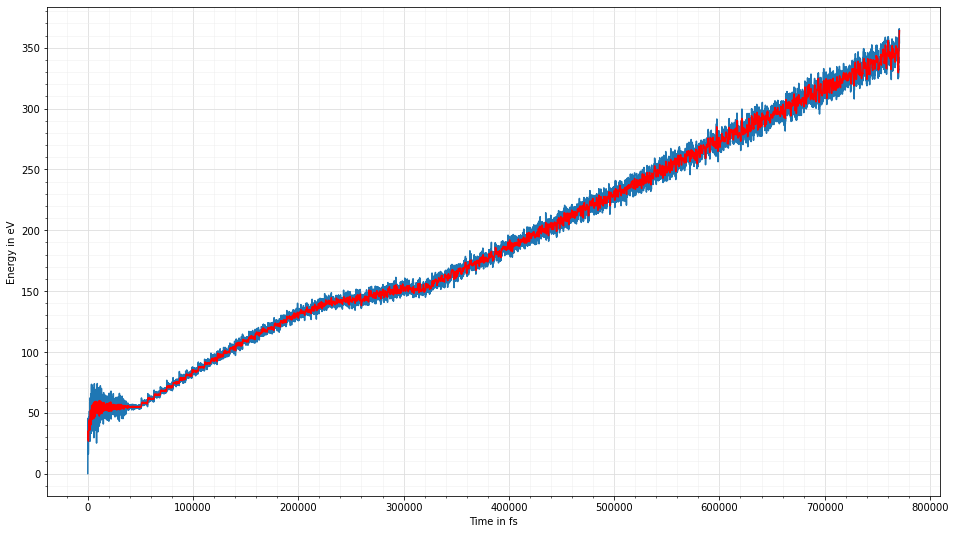

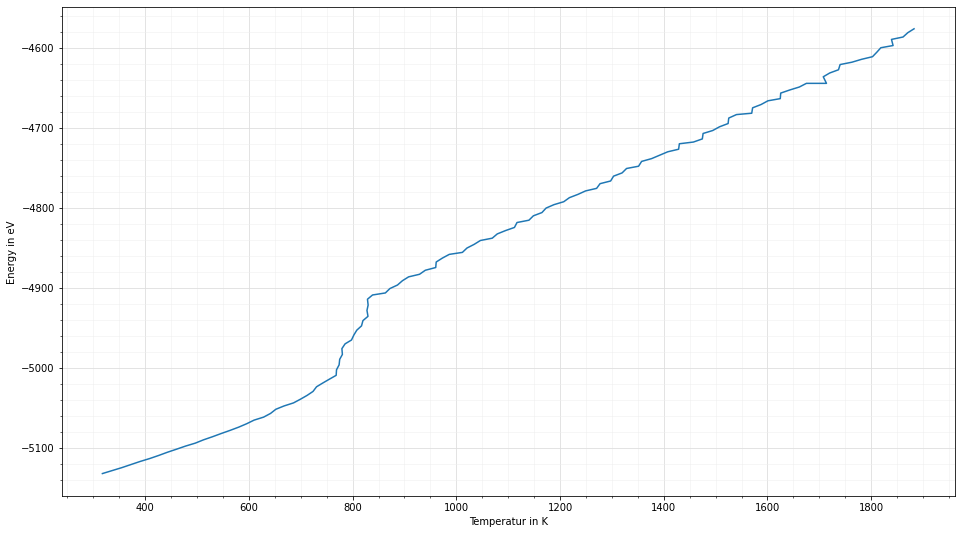

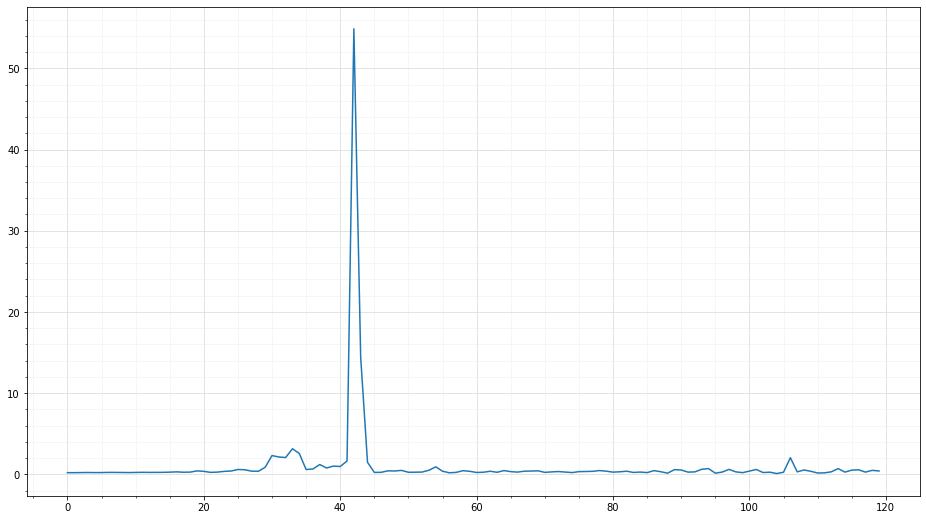

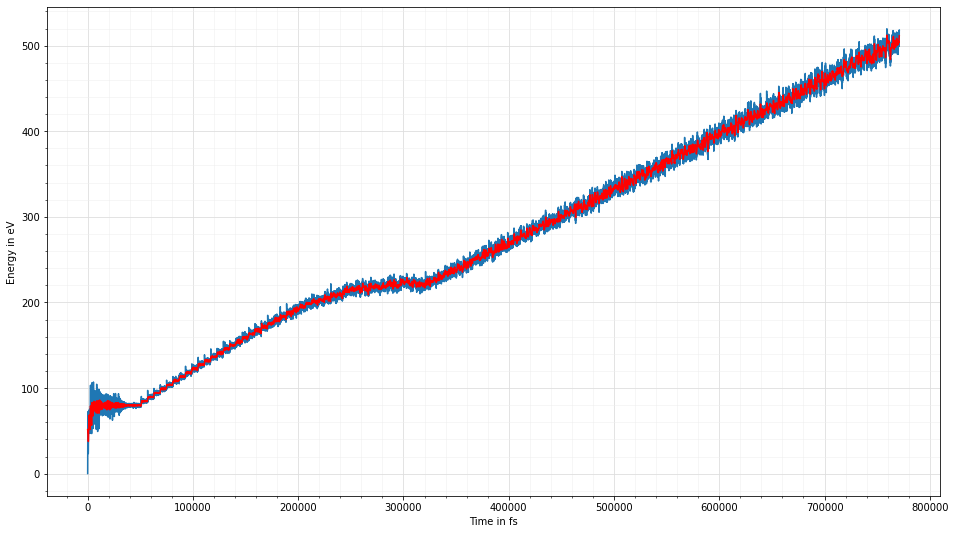

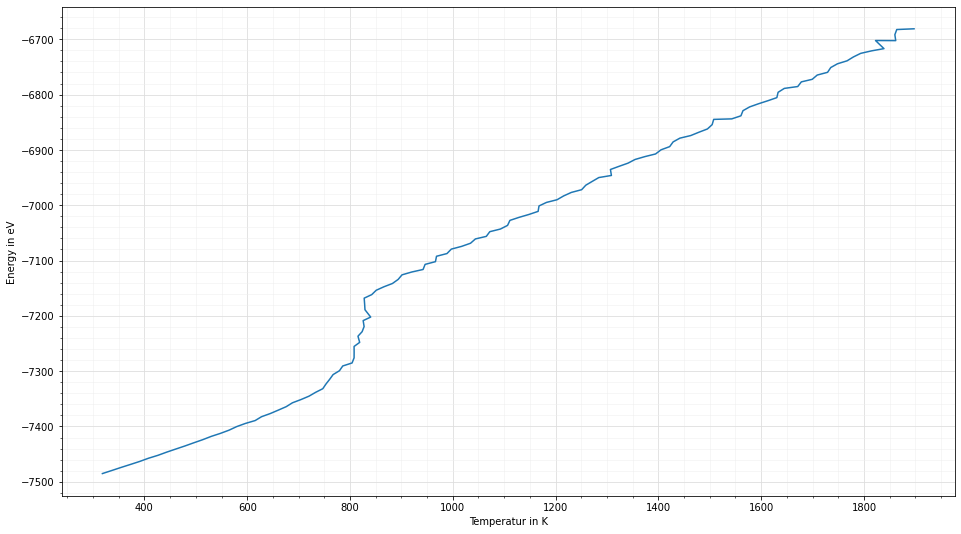

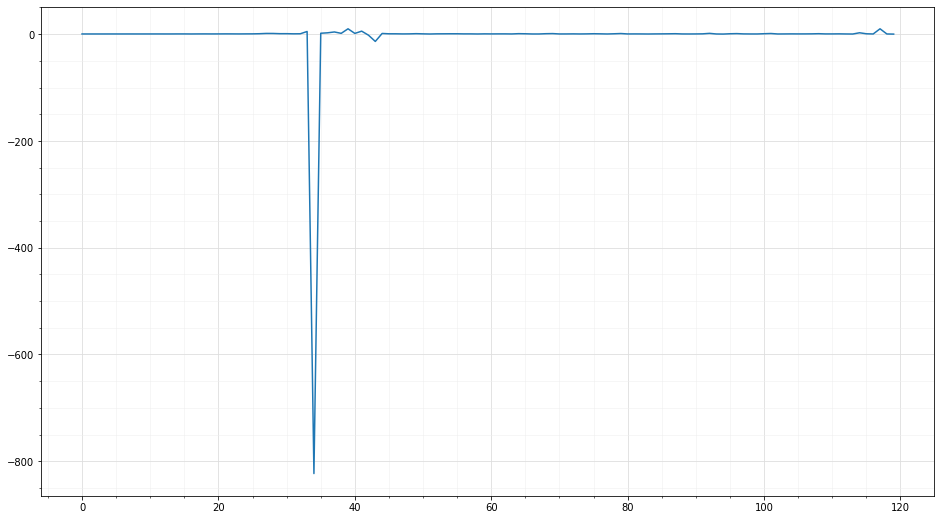

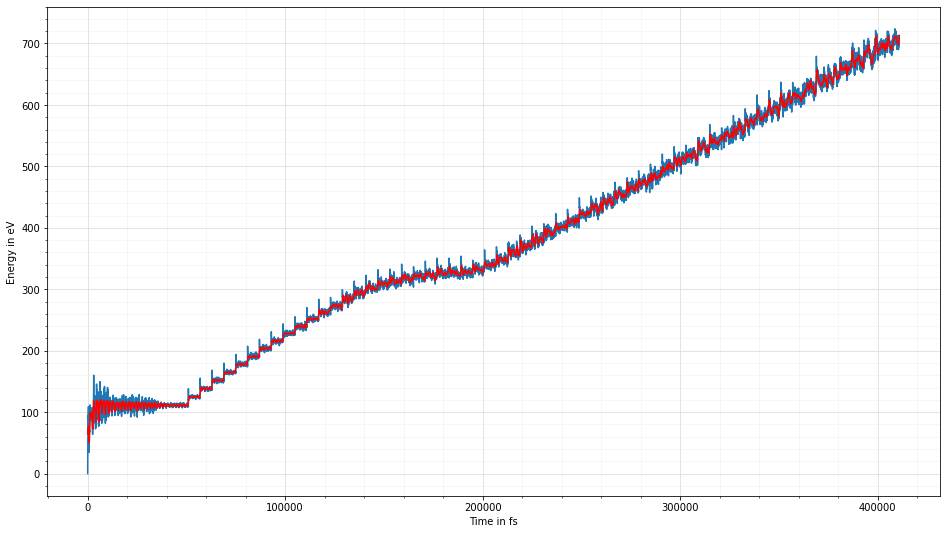

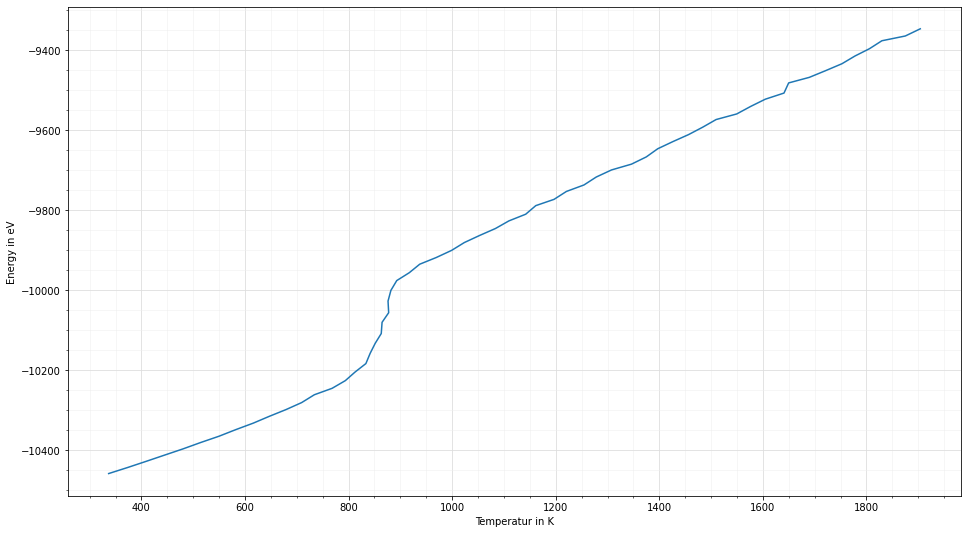

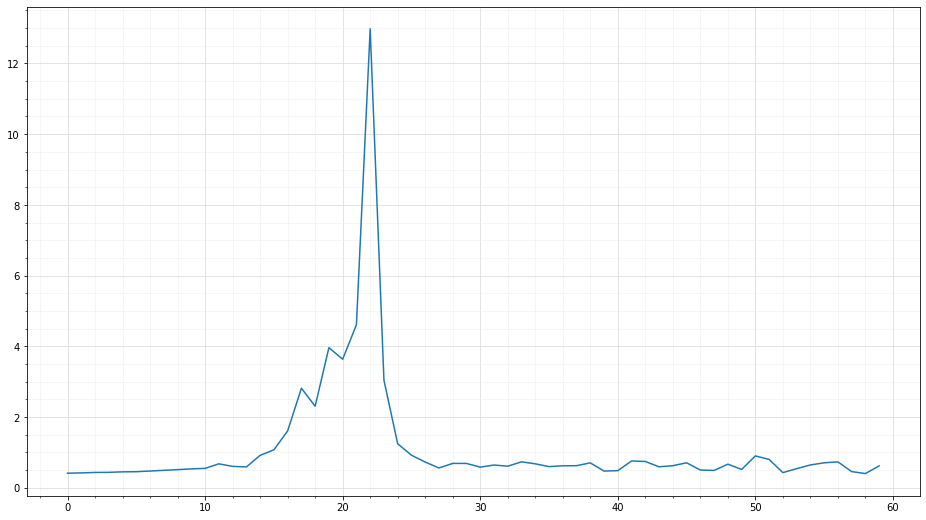

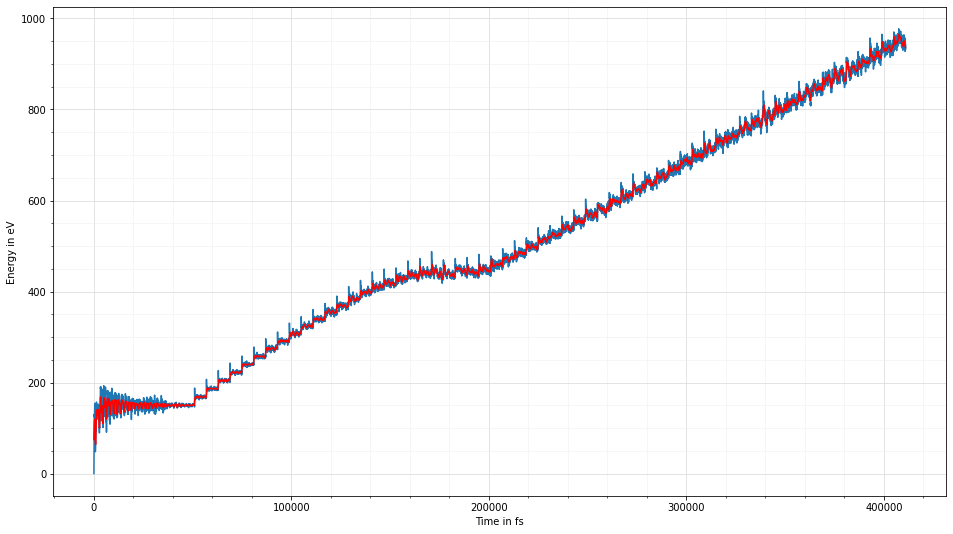

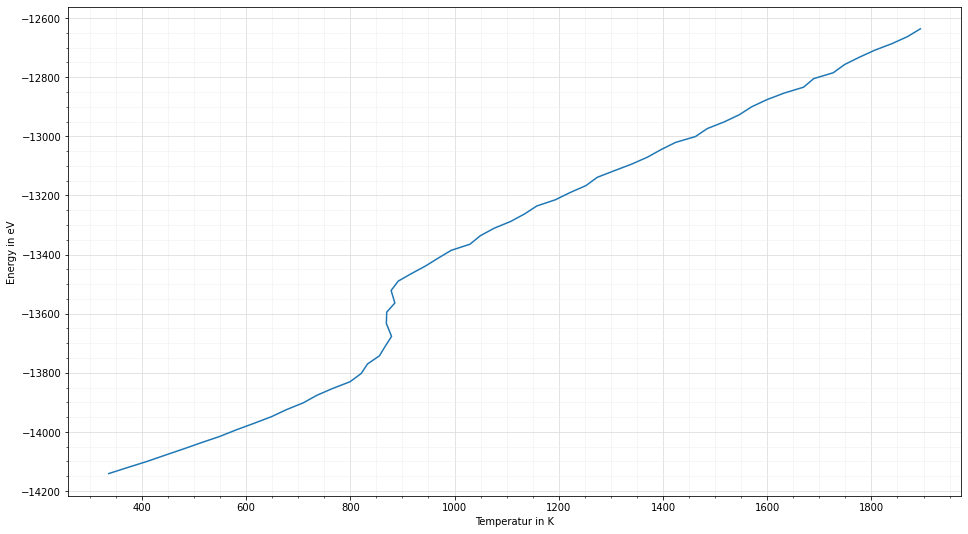

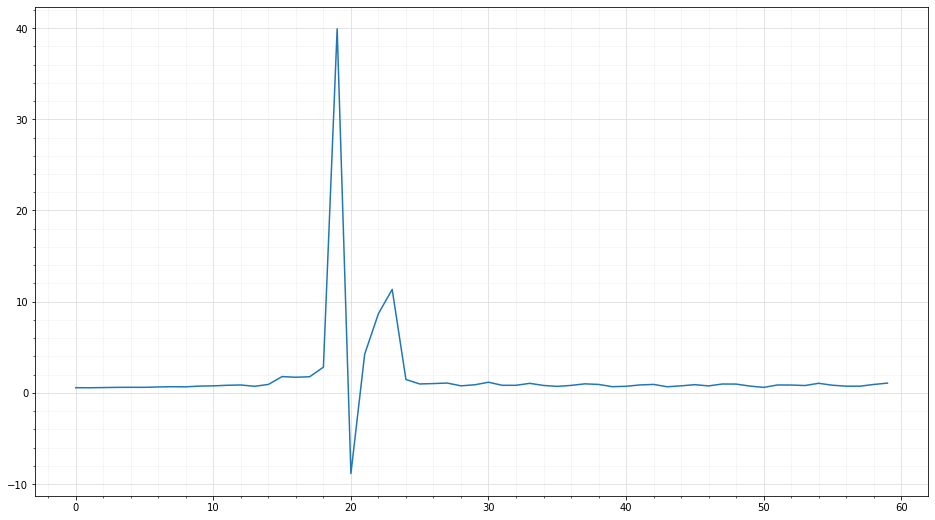

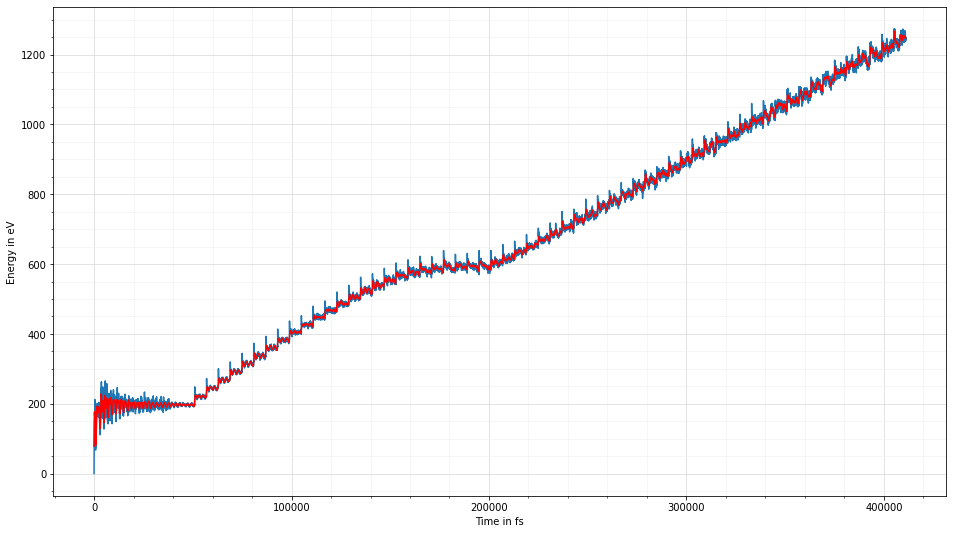

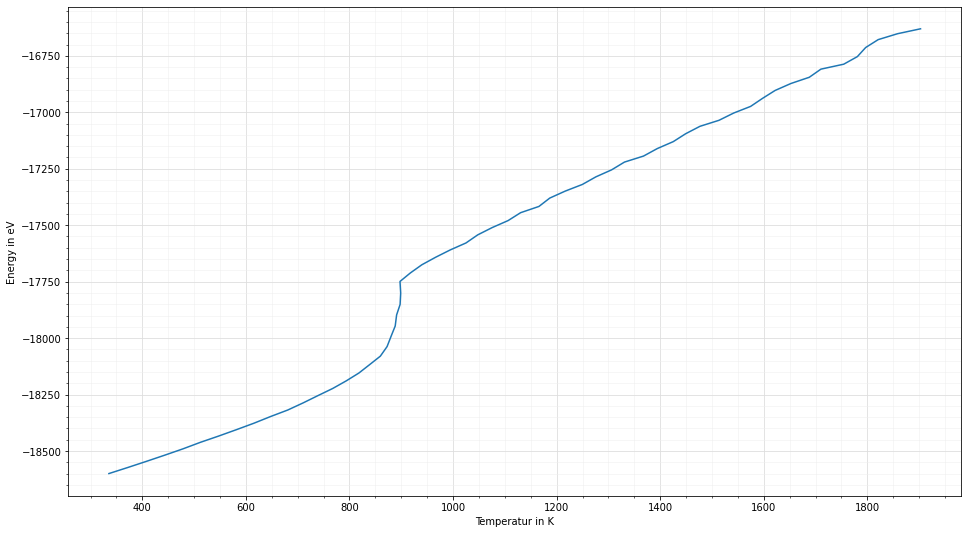

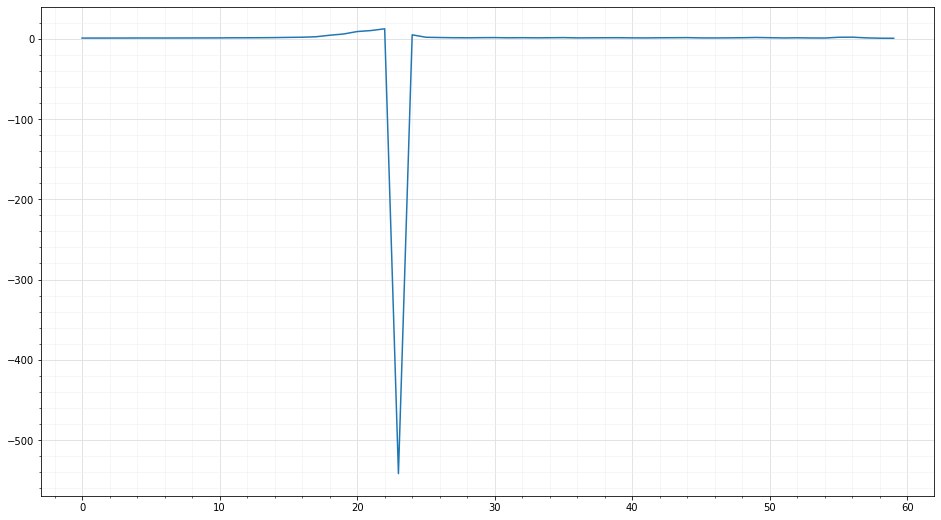

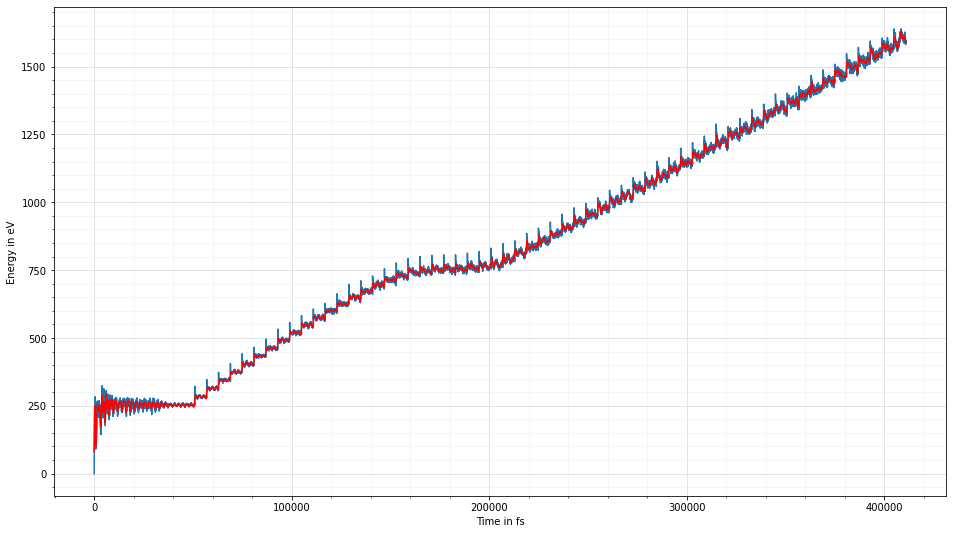

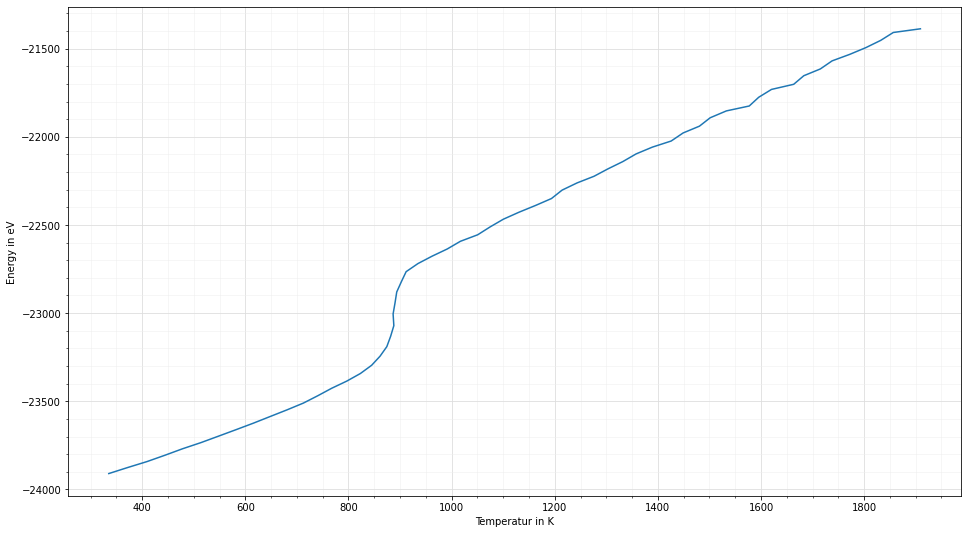

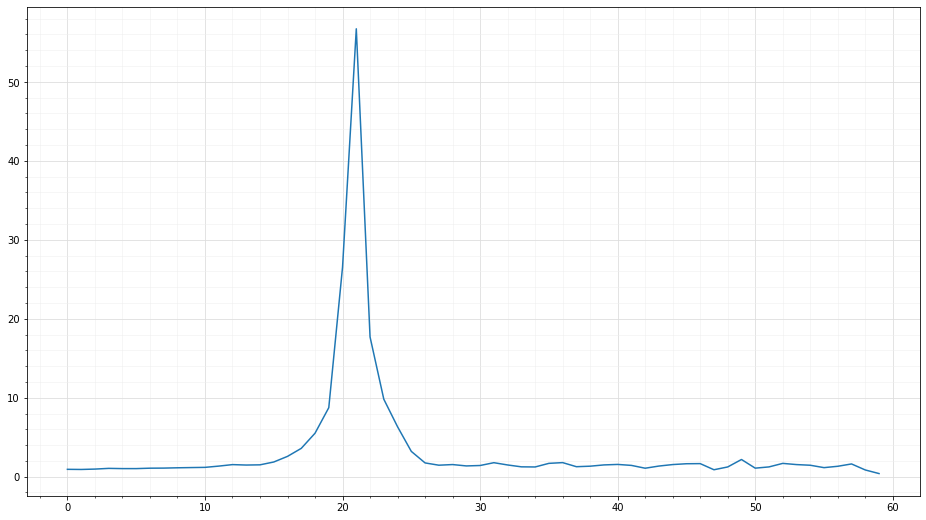

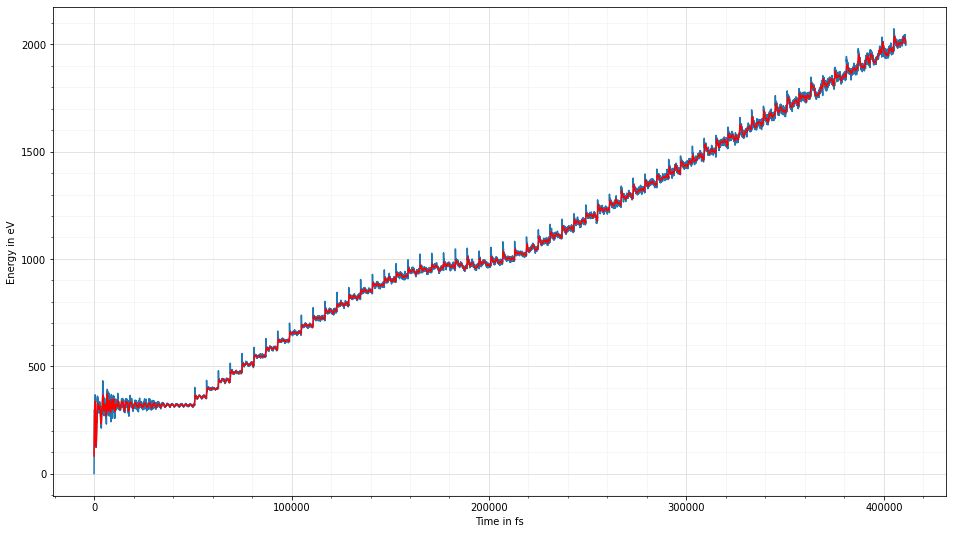

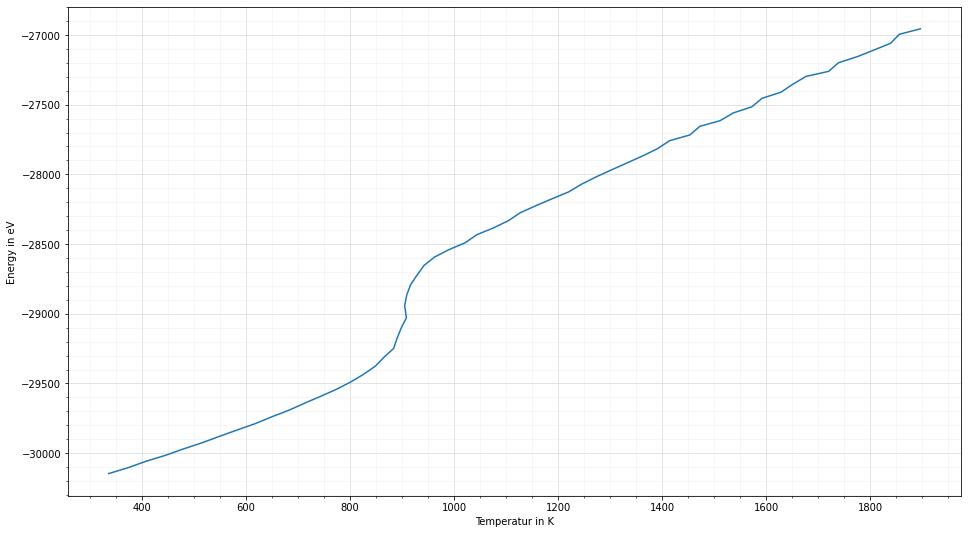

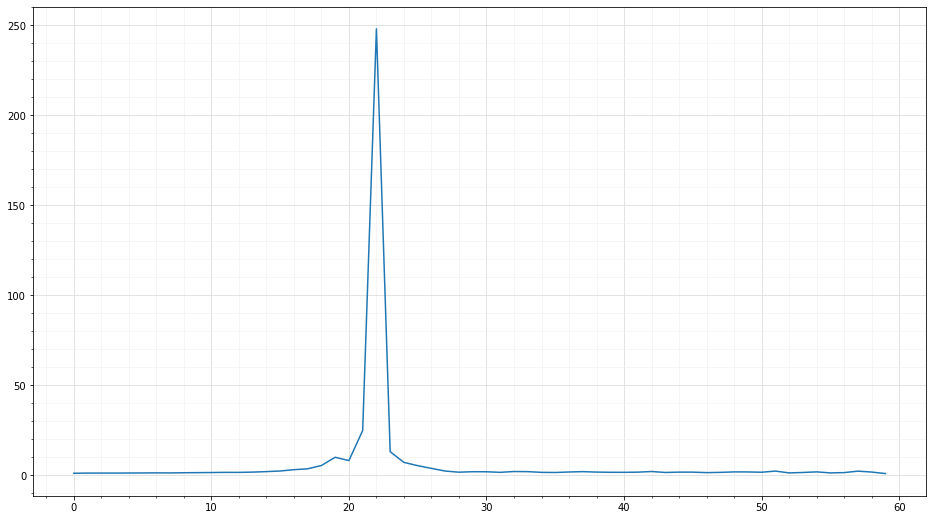

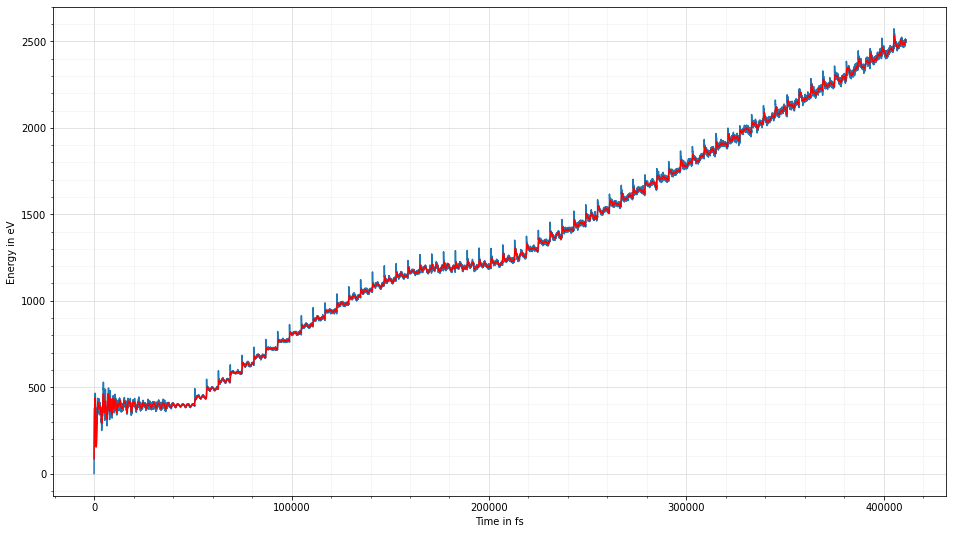

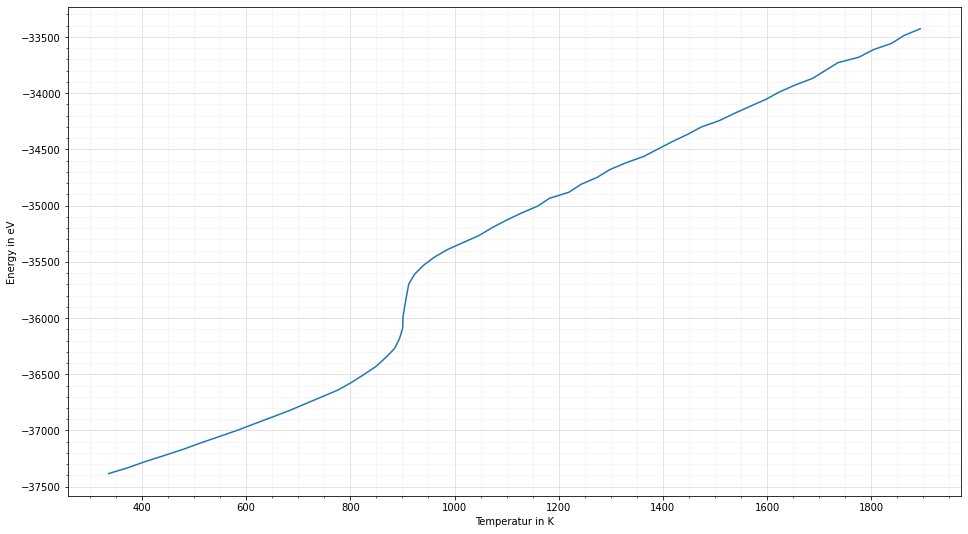

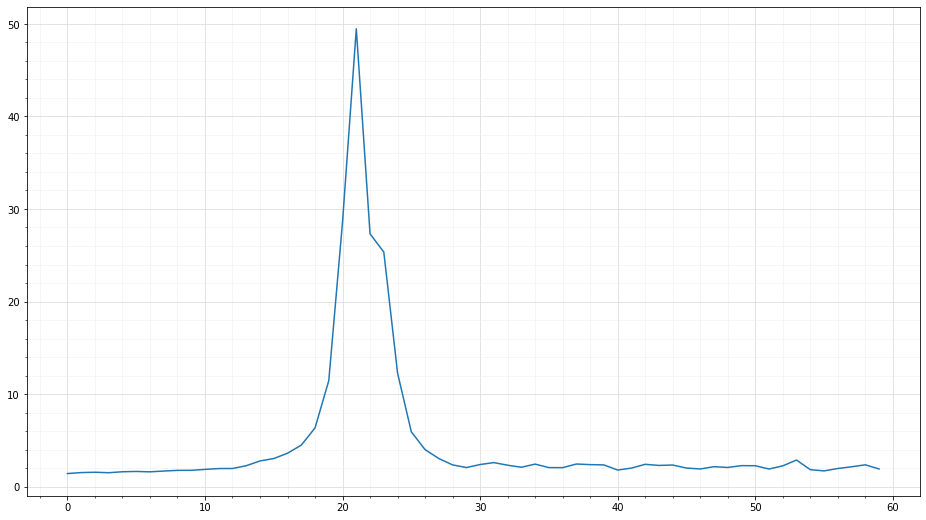

In [159]:
#Main  
#full program takes around 14 (22-8 couse i want to sleep) hours could be faster if no 13 and 14
dataMaker()
plotter()

In [16]:
#Function Test
#plot data
#dataPlotterKineticEnergy(1)
#dataPlotterEnergyTemperatur(1)

In [ ]:
#incase the 13 and 14 take too long
for layerID in range(12-3+1):
        dataPlotterKineticEnergy(layerID+3)
        dataPlotterEnergyTemperatur(layerID+3)

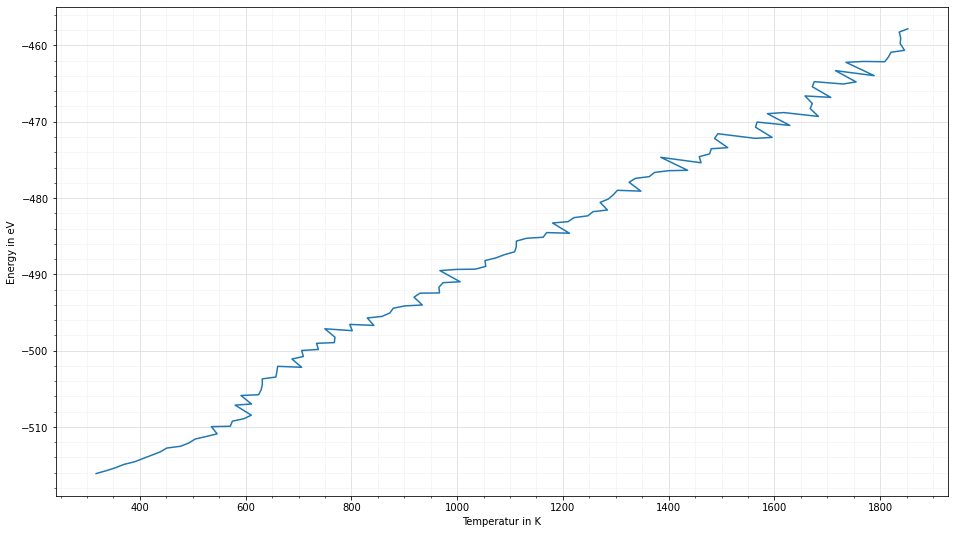

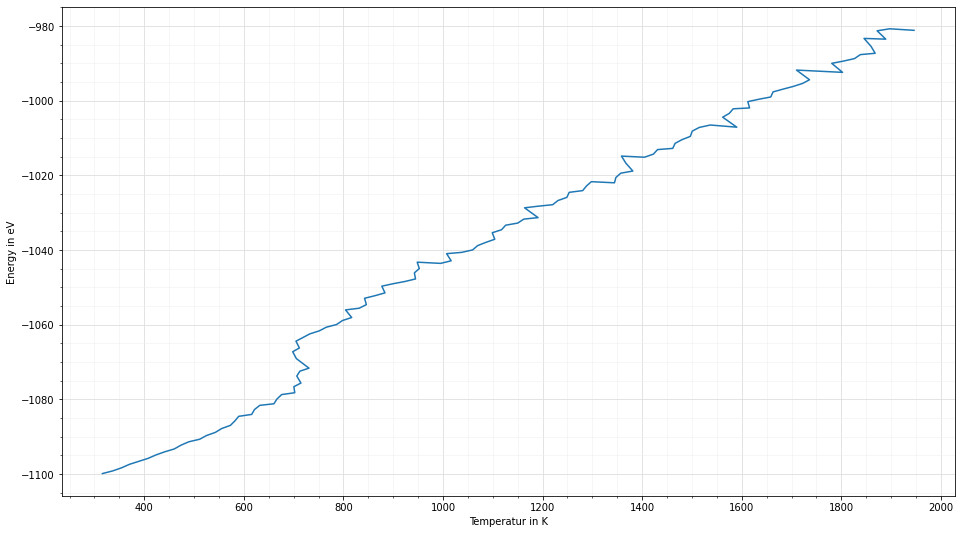

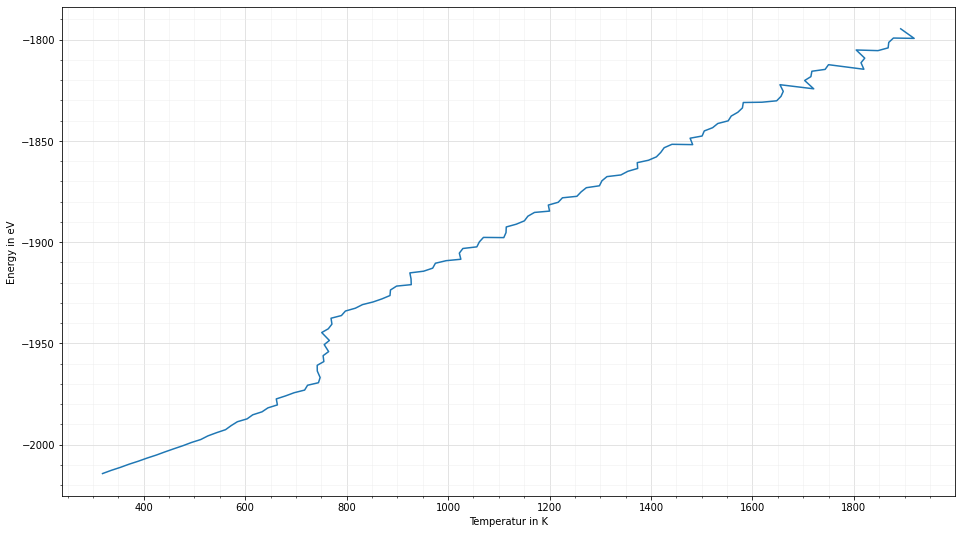

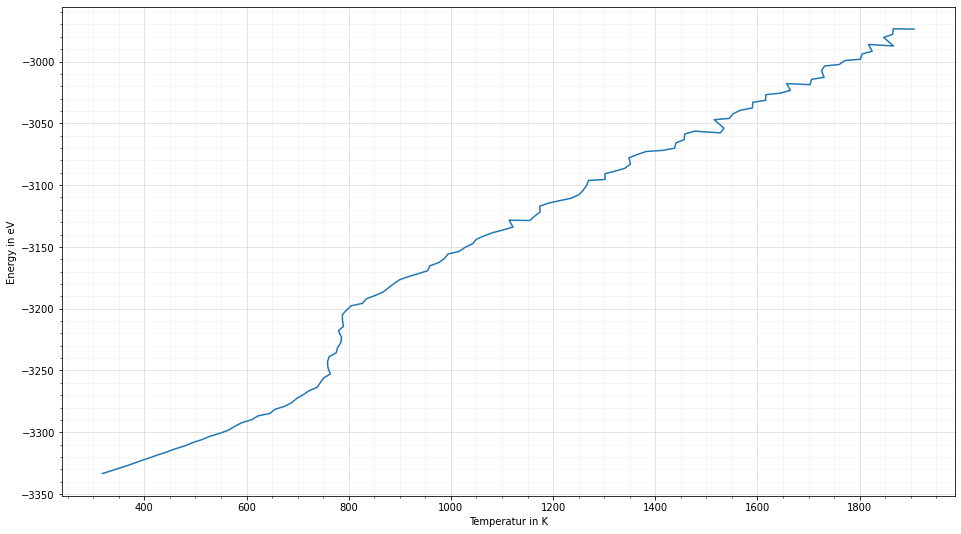

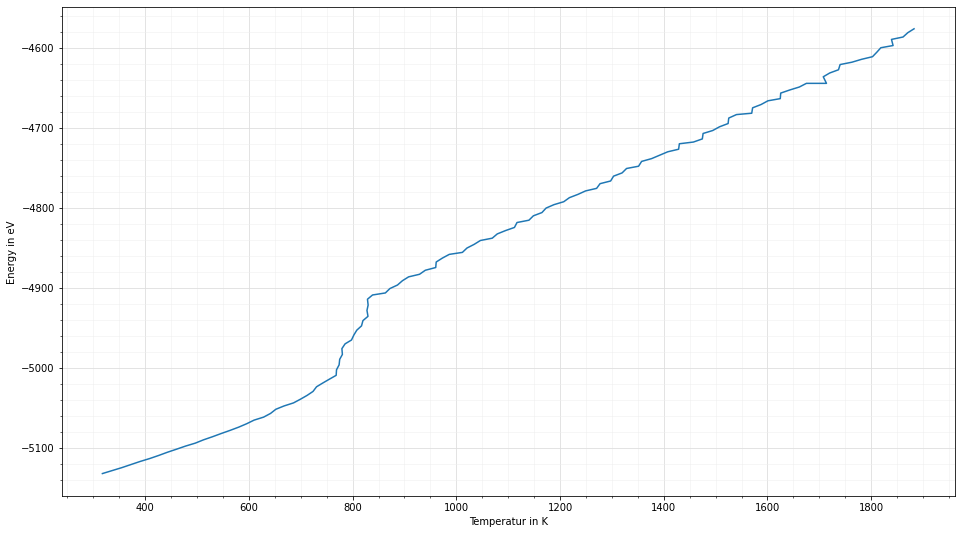

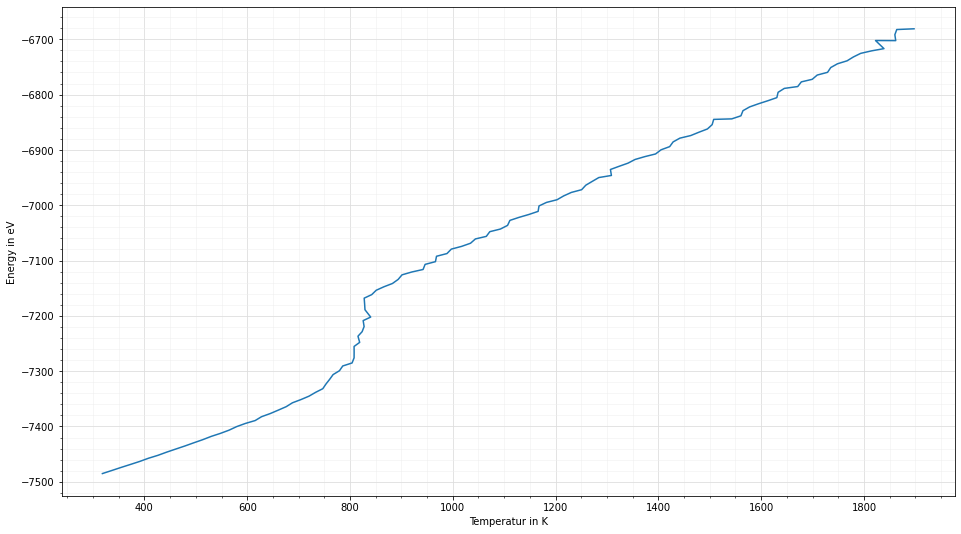

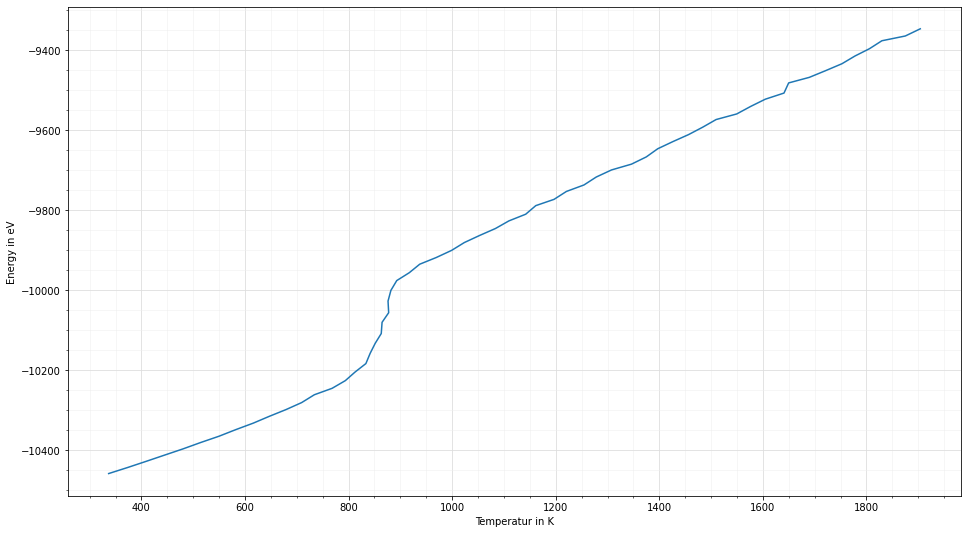

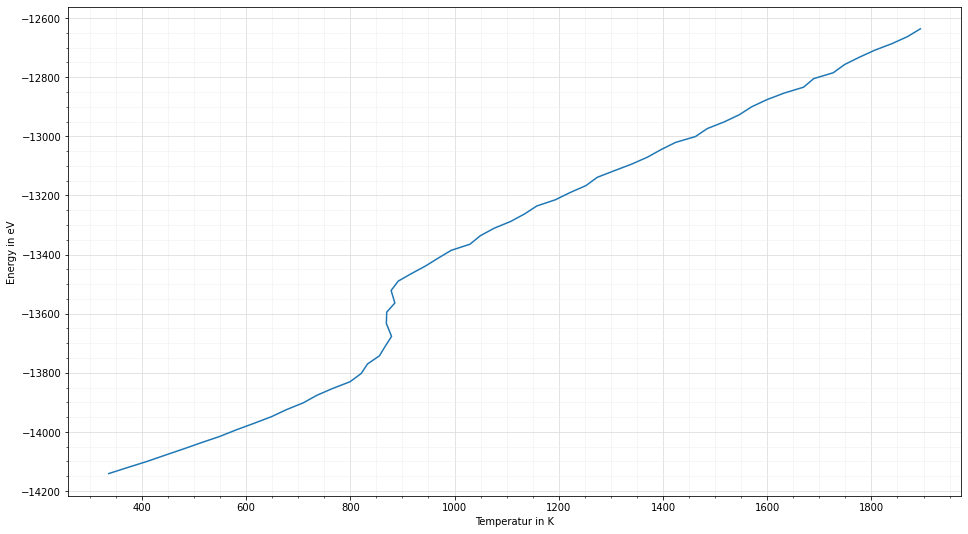

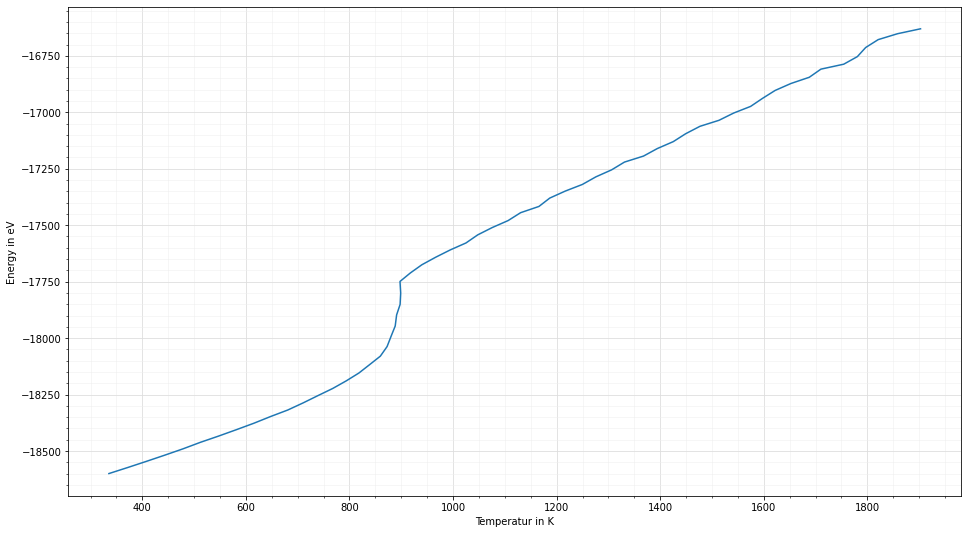

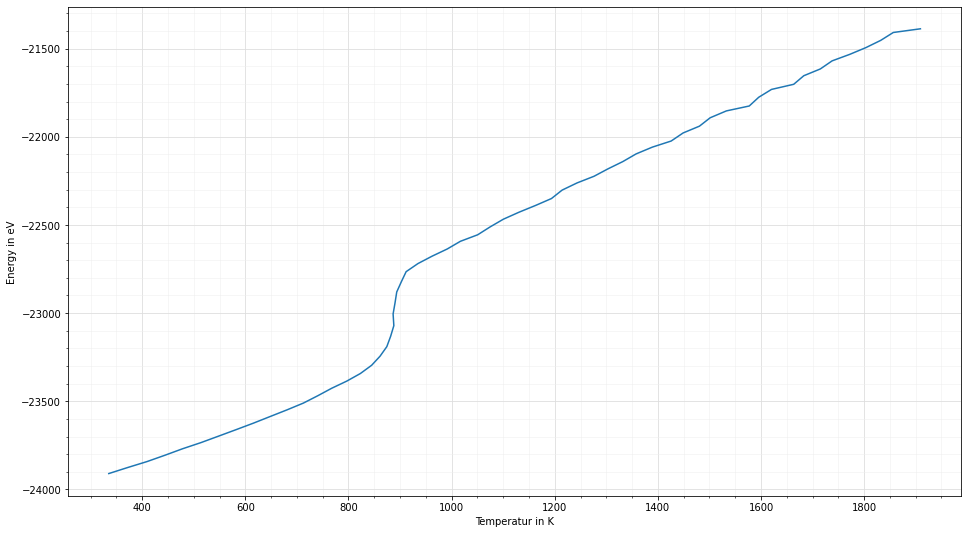

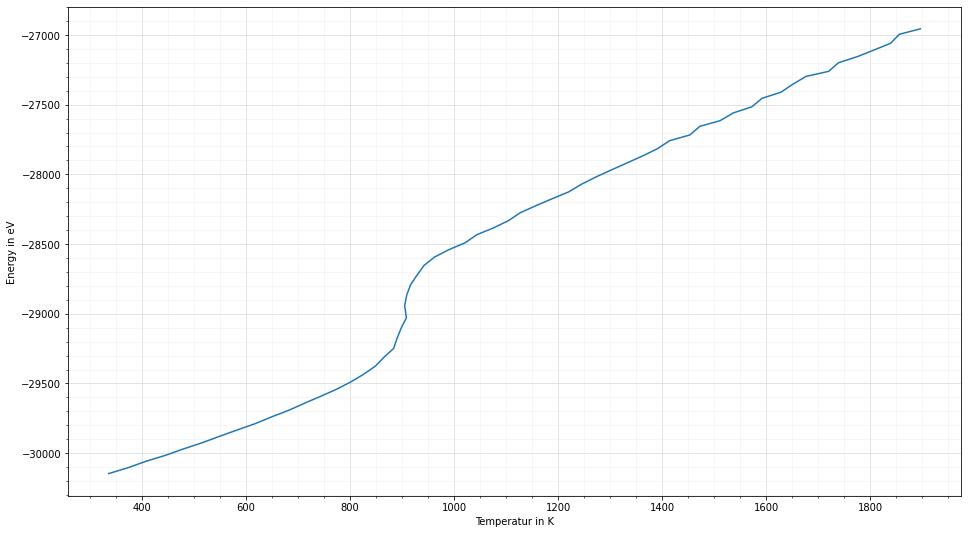

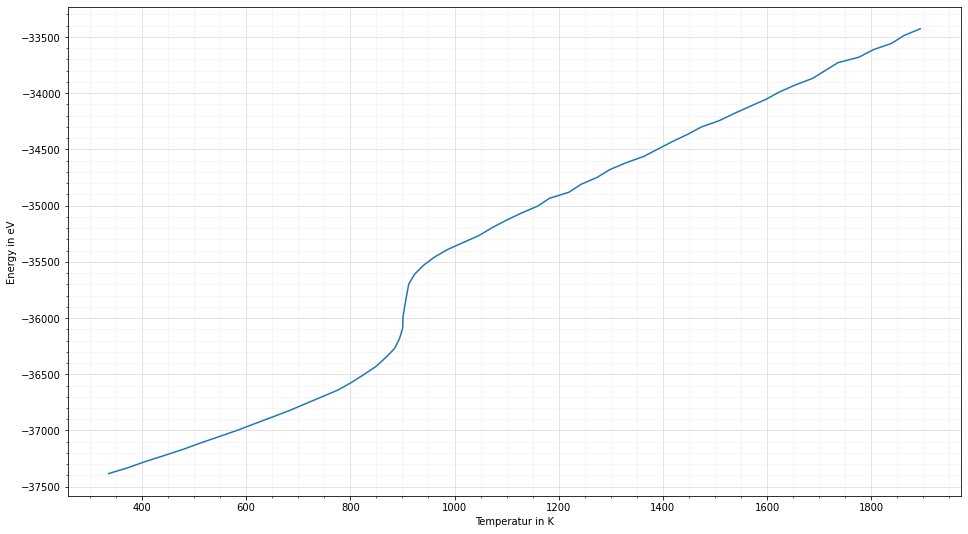

In [160]:
#tex generator for easy use lol
backSlash = " \n"

def texGeneratorFigures():
    energyFileLocation = basicDataLocation + "/texFigures" + ".tex"
    
    #open file
    file = open(energyFileLocation,'w')
    
    #work
    for layerID in range(14-3+1):
        file.write(texGenerator(layerID+3))
        
    #close file
    file.close()

def texGenerator(layerID):
    '''
    \begin{figure}[!h]
        \begin{center}
            \includegraphics[scale=1]{Figure/plotAtomTimes.png}
        \end{center}
        \caption[Simulationtime]{Simulationtime from 8 to 192 Atoms }
        \label{PlotAtomTimes}
    \end{figure}
    '''
    #return String that can be written to the 
    returnString = "% Figures for " + readClusterSizes(layerID) + " Atoms" + backSlash 
    
    #plot time to kin
    '''
    titleString = "Gold Cluster Simulation with " + readClusterSizes(layerID) + " Atoms" 
    #tex
    returnString += "\\begin{figure}[!h]" + backSlash
    returnString += "    \\begin{center}" + backSlash
    returnString += "        \includegraphics[scale=1]{" +dataPlotterKineticEnergy(layerID) + "}"+ backSlash
    returnString += "    \end{center}"+ backSlash
    returnString += "    \caption[" + titleString + "]{" +titleString +"}" + backSlash
    returnString += "    \label{GoldClusterSimulationKineticTime" + readClusterSizes(layerID) + "}" + backSlash
    returnString += "\end{figure}"+ backSlash
    returnString += backSlash
    '''
    
    #2 plot temperatur to energy
    titleString = "Gold Cluster Simulation with " + readClusterSizes(layerID) + " Atoms" 
    #tex
    returnString += "\\begin{figure}[!h]" + backSlash
    returnString += "    \\begin{center}" + backSlash
    returnString += "        \includegraphics[scale=1.15]{" + dataPlotterPotentialEnergyTemperatur(layerID) + "}"+ backSlash
    returnString += "    \end{center}"+ backSlash
    returnString += "    \caption[" + titleString + "]{" +titleString +"}" + backSlash
    returnString += "    \label{GoldClusterSimulationTemperaturEnergy" + readClusterSizes(layerID) + "}" + backSlash
    returnString += "\end{figure}"+ backSlash
    returnString += backSlash
    
    '''
    #3 plot gradient of the two
    titleString = "Gradient of Temperatur and Energy for the Gold Cluster Simulation with " + readClusterSizes(layerID) + " Atoms" 
    #tex
    returnString += "\\begin{figure}[!h]" + backSlash
    returnString += "    \\begin{center}" + backSlash
    returnString += "        \includegraphics[scale=1.25]{" + dataPlotterDiffEnergyTemperatur(layerID) + "}"+ backSlash
    returnString += "    \end{center}"+ backSlash
    returnString += "    \caption[" + titleString + "]{" +titleString +"}" + backSlash
    returnString += "    \label{GoldClusterSimulationGradient" + readClusterSizes(layerID) + "}" + backSlash
    returnString += "\end{figure}"+ backSlash
    returnString += backSlash
    '''
    
    #
    return returnString
    
texGeneratorFigures()